<a href="https://colab.research.google.com/github/JanjaTomic/OSiRV/blob/main/obradaslike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, filters
from skimage.transform import resize
import zipfile
from google.colab import files
import os
from keras.applications import VGG16
from skimage import io, color, filters, feature
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d landlord/handwriting-recognition

 99% 1.25G/1.26G [00:16<00:00, 94.3MB/s]
100% 1.26G/1.26G [00:16<00:00, 80.2MB/s]


In [ ]:
with zipfile.ZipFile('/content/handwriting-recognition.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
train_dir = "/content/train_v2/train/"
test_dir = "/content/test_v2/test/"
validation_dir = "/content/validation_v2/validation/"

In [ ]:
def load_images_from_directory(directory, max_images=100000):
    images = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Construct the full path to the image file
            filepath = os.path.join(directory, filename)
            # Read the image using OpenCV
            image = cv2.imread(filepath)
            if image is not None:
                images.append(image)
                count += 1
                if count >= max_images:
                    break
    return images

In [ ]:
images = load_images_from_directory(train_dir)

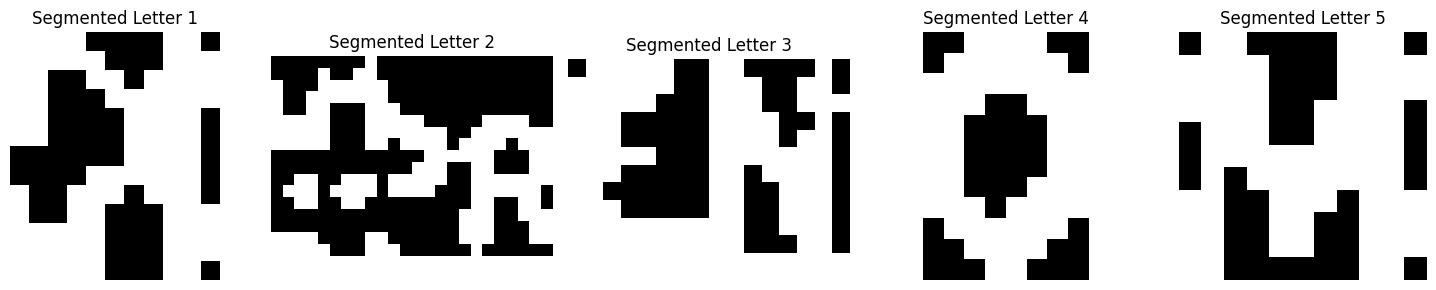

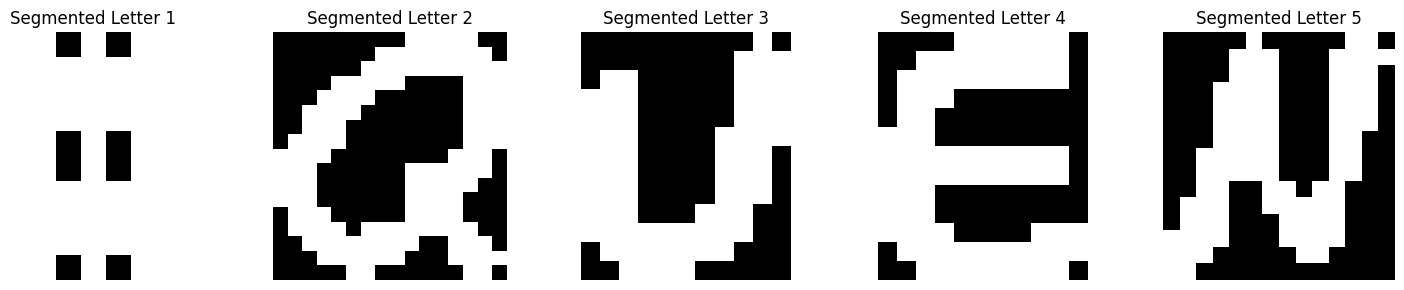

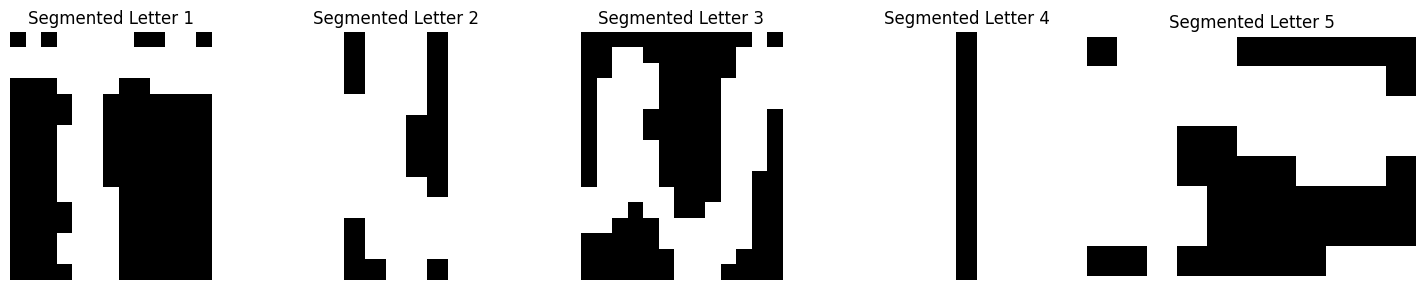

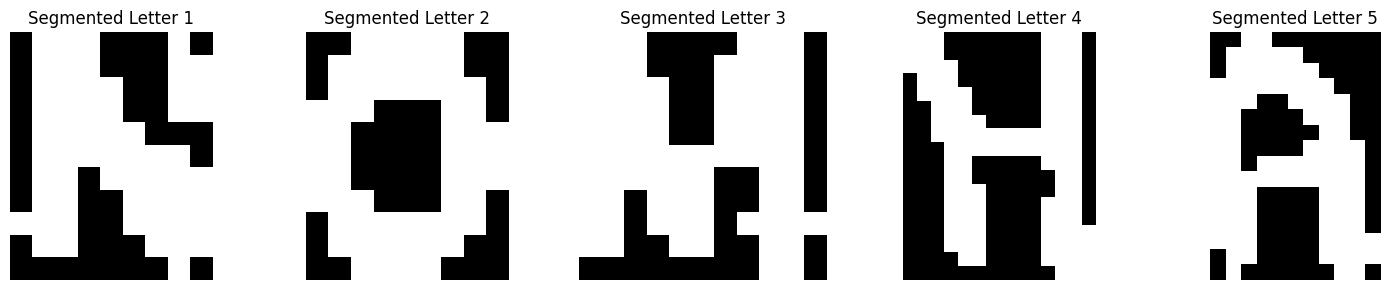

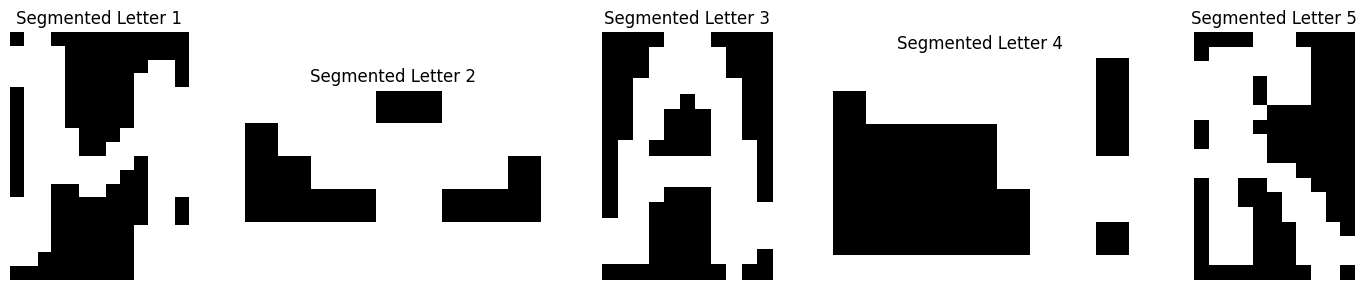

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

filename_word_mapping = pd.read_csv('/content/written_name_train_v2.csv')

def preprocess_image(image):
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def binarize_image(image):
    if image is None:
        return None
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    return binary

def segment_letters(image):
    if image is None:
        return []
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmented_letters = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        contour_area = cv2.contourArea(contour)
        if contour_area < 10:
            continue
        letter = image[y:y+h, x:x+w].copy()  # Make a copy to prevent memory issues
        segmented_letters.append((x, letter))  # Store the x-coordinate along with the letter

    # Sort the segmented letters based on their x-coordinate
    segmented_letters.sort(key=lambda x: x[0])

    # Extract only the letter images from the sorted list
    sorted_letters = [letter for _, letter in segmented_letters]

    return sorted_letters

def extract_features(image):
    if image is None:
        return None
    # Resize the image to a fixed size (e.g., 32x32) and flatten the pixel values
    resized_image = cv2.resize(image, (32, 32))
    features = resized_image.flatten()
    return features

def process_images(images):
    processed_data = []
    segmented_letters_all = []

    for image in images:
        # Preprocess the image
        processed_image = preprocess_image(image)

        # Binarize the image
        binary_image = binarize_image(processed_image)

        # Segment letters in the image
        segmented_letters = segment_letters(binary_image)
        segmented_letters_all.extend(segmented_letters)  # Store segmented letters

        # Extract features from segmented letters
        for letter_image in segmented_letters:
            features = extract_features(letter_image)
            if features is not None:
                processed_data.append(features)

    return np.array(processed_data), segmented_letters_all

# Load images from a directory in batches
def load_images_from_directory(directory, batch_size):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath)
            if image is not None:
                images.append(image)
            else:
                print(f"Failed to load image: {filepath}")

            # Check if the batch size is reached
            if len(images) >= batch_size:
                yield images
                images = []

    # Yield remaining images (if any)
    if images:
        yield images

# Define batch size
batch_size = 10

# Process images in batches
train_dir = "/content/train_v2/train/"
processed_data_all = []
segmented_letters_all = []
for batch_images in load_images_from_directory(train_dir, batch_size):
    batch_processed_data, batch_segmented_letters = process_images(batch_images)
    processed_data_all.extend(batch_processed_data)
    segmented_letters_all.extend(batch_segmented_letters)

# Visualize segmented letters for the first few samples
num_samples = 5
for i in range(num_samples):
    plt.figure(figsize=(15, 3))
    sample_letters = segmented_letters_all[i*5:i*5+5]  # Change the range to visualize first 5 letters of the first word
    for j, letter in enumerate(sample_letters):
        plt.subplot(1, 5, j + 1)
        plt.imshow(letter, cmap='gray')
        plt.title(f'Segmented Letter {j+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
csv_file = 'written_name_test_v2.csv'  # Replace 'your_csv_file.csv' with the actual filename
df = pd.read_csv(csv_file)
filename_word_mapping = dict(zip(df["FILENAME"], df["IDENTITY"]))
# Assuming segmented_letters_all contains the segmented letters in the picture
# You need to match each letter with its filename
# Then use the filename to find the corresponding word in the DataFrame

# Iterate over segmented letters and filenames
# Iterate over segmented letters
for i, letters in enumerate(segmented_letters_all):
    # Check if the index exists in the filename_word_mapping
    if i < len(filename_word_mapping):
        filename = list(filename_word_mapping.keys())[i]
        word = filename_word_mapping[filename]
        # Check if the number of segmented letters matches the length of the word
        if len(letters) == len(word):
            # Now you can associate each segmented letter with the corresponding letter in the word
            letter_word_mapping = dict(zip(word, letters))
            print(f"The segmented letters correspond to the word: {word}")
            print("Letter to segmented letter mapping:", letter_word_mapping)
        else:
            print(f"Number of segmented letters ({len(letters)}) doesn't match the number of letters in the word ({len(word)}) for filename: {filename}")
            # Handle the discrepancy here (e.g., skip the word, log an error, etc.)
    else:
        print("Error: Index out of range for filename_word_mapping")



Number of segmented letters (19) doesn't match the number of letters in the word (5) for filename: TEST_0001.jpg
Number of segmented letters (18) doesn't match the number of letters in the word (8) for filename: TEST_0002.jpg
Number of segmented letters (18) doesn't match the number of letters in the word (4) for filename: TEST_0003.jpg
Number of segmented letters (21) doesn't match the number of letters in the word (5) for filename: TEST_0004.jpg
Number of segmented letters (16) doesn't match the number of letters in the word (7) for filename: TEST_0005.jpg
Number of segmented letters (18) doesn't match the number of letters in the word (6) for filename: TEST_0006.jpg
Number of segmented letters (20) doesn't match the number of letters in the word (9) for filename: TEST_0007.jpg
Number of segmented letters (18) doesn't match the number of letters in the word (5) for filename: TEST_0008.jpg
Number of segmented letters (16) doesn't match the number of letters in the word (8) for filenam

TypeError: object of type 'float' has no len()

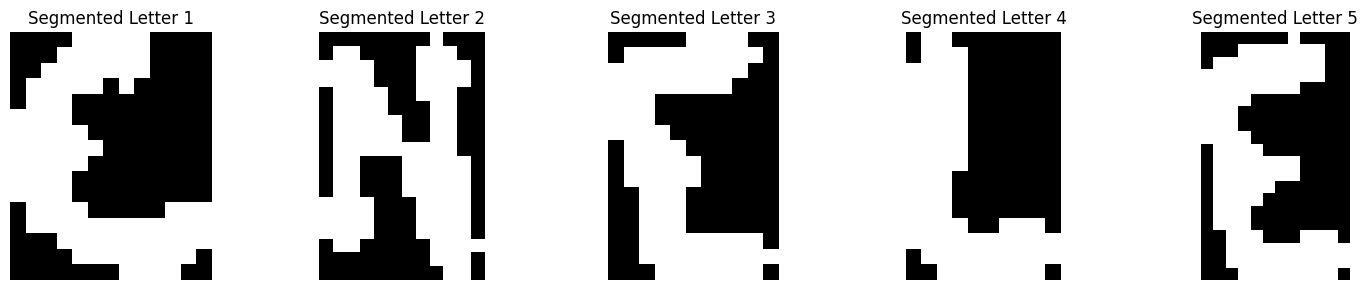

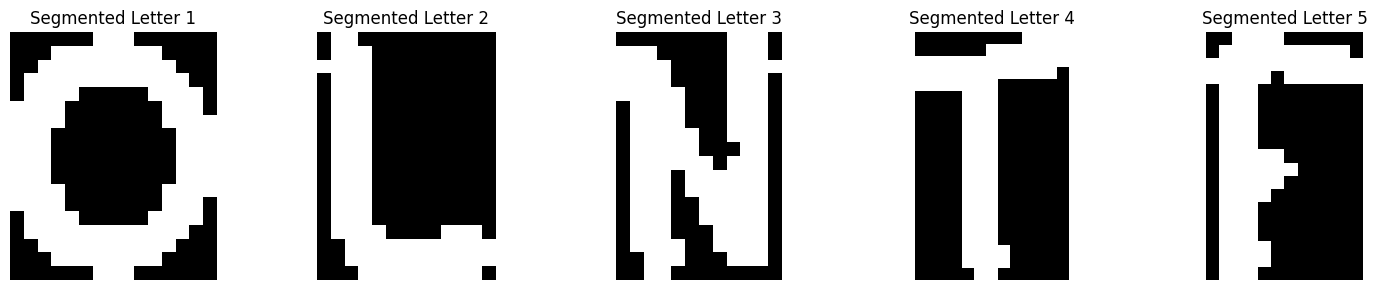

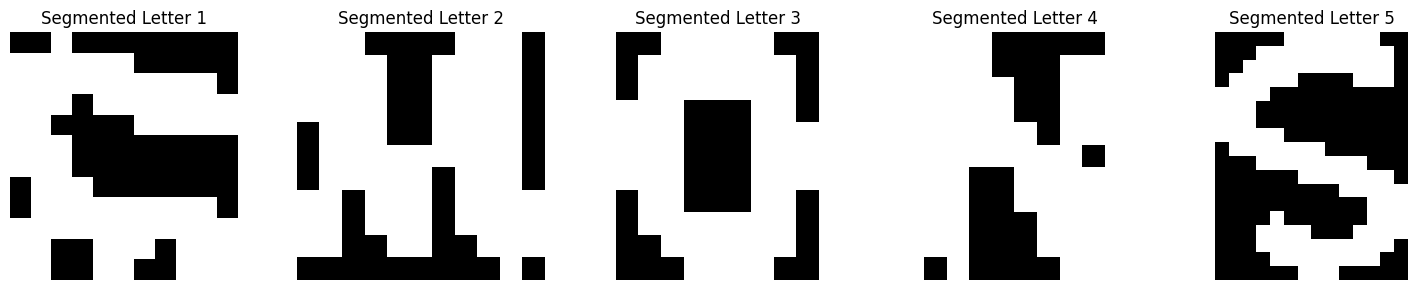

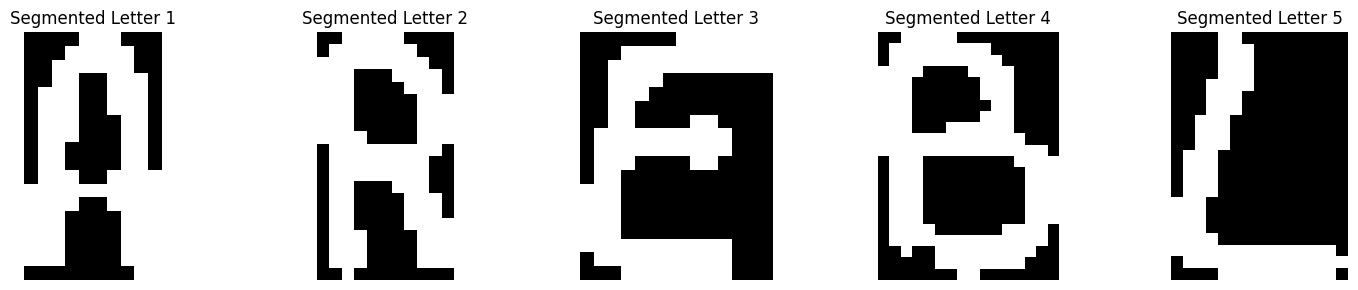

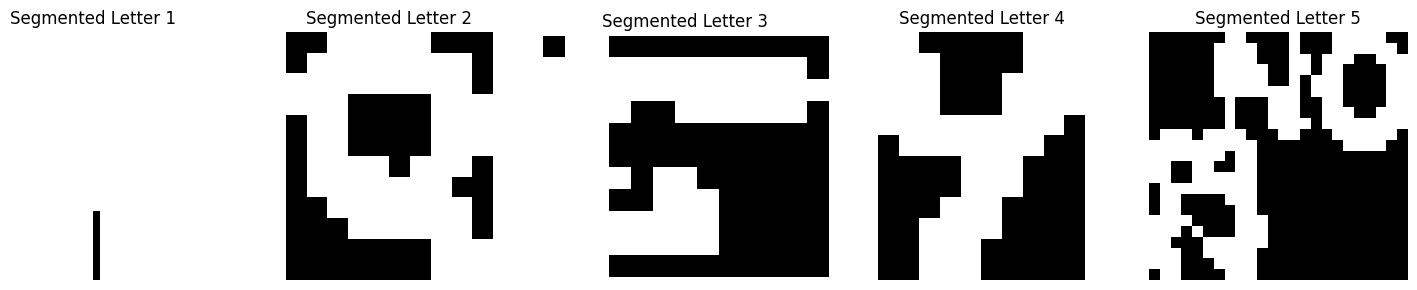

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def binarize_image(image):
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    return binary

def segment_letters(image):
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmented_letters = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        contour_area = cv2.contourArea(contour)
        if contour_area < 10:
            continue
        letter = image[y:y+h, x:x+w].copy()  # Make a copy to prevent memory issues
        segmented_letters.append(letter)

    return segmented_letters

def extract_features(image):
    # Resize the image to a fixed size (e.g., 32x32) and flatten the pixel values
    resized_image = cv2.resize(image, (32, 32))
    features = resized_image.flatten()
    return features

def process_images(images):
    processed_data = []
    segmented_letters_all = []

    for image in images:
        # Preprocess the image
        processed_image = preprocess_image(image)
        if processed_image is None:
            print("Error: Failed to preprocess image")
            continue

        # Binarize the image
        binary_image = binarize_image(processed_image)
        if binary_image is None:
            print("Error: Failed to binarize image")
            continue

        # Segment letters in the image
        segmented_letters = segment_letters(binary_image)
        segmented_letters_all.extend(segmented_letters)  # Store segmented letters

        # Extract features from segmented letters
        for letter_image in segmented_letters:
            features = extract_features(letter_image)
            processed_data.append(features)

    return np.array(processed_data), segmented_letters_all

# Load images from a directory in batches
def load_images_from_directory(directory, batch_size):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath)
            if image is not None:
                images.append(image)
            else:
                print(f"Failed to load image: {filepath}")

            # Check if the batch size is reached
            if len(images) >= batch_size:
                yield images
                images = []

    # Yield remaining images (if any)
    if images:
        yield images

# Define batch size
batch_size = 10

# Process images in batches
train_dir = "/content/train_v2/train/"
processed_data_all = []
segmented_letters_all = []
for batch_images in load_images_from_directory(train_dir, batch_size):
    batch_processed_data, batch_segmented_letters = process_images(batch_images)
    processed_data_all.extend(batch_processed_data)
    segmented_letters_all.extend(batch_segmented_letters)

# Visualize segmented letters for the first few samples
num_samples = 5
for i in range(num_samples):
    plt.figure(figsize=(15, 3))
    sample_letters = segmented_letters_all[i*5:i*5+5]  # Change the range to visualize first 5 letters of the first word
    for j, letter in enumerate(sample_letters):
        plt.subplot(1, 5, j + 1)
        plt.imshow(letter, cmap='gray')
        plt.title(f'Segmented Letter {j+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
#vladina
def preprocess_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def binarize_image(image):
    # Apply adaptive thresholding to binarize the image
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    return binary

def segment_letters(image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store segmented letters
    segmented_letters = []

    # Iterate through each contour
    for contour in contours:
        # Get bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out contours based on area
        contour_area = cv2.contourArea(contour)
        if contour_area < 10:  # Adjust this threshold as needed
            continue

        # Extract the segmented letter
        letter = image[y:y+h, x:x+w]
        # Append the segmented letter along with its bounding box coordinates to the list
        segmented_letters.append((x, letter))
        # Draw bounding box around the letter
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Sort segmented letters based on x-coordinate
    segmented_letters.sort(key=lambda x: x[0])

    # Extract only the segmented letters (excluding bounding box coordinates) from the sorted list
    segmented_letters = [letter for _, letter in segmented_letters]

    return image, segmented_letters

def process_images(images):
    processed_letters = []

    for image in images:
        # Preprocess the image
        processed_image = preprocess_image(image)

        # Binarize the image
        binary_image = binarize_image(processed_image)

        # Segment letters in the image
        segmented_image, segmented_letters = segment_letters(binary_image)

        # Add segmented letters to the list
        processed_letters.extend(segmented_letters)

    return processed_letters


# Process the images and gather segmented letters
letters = process_images(images)

In [ ]:
for letter in enumerate(letters[:30]):
    cv2_imshow(letter[1])

cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'letters' is not defined

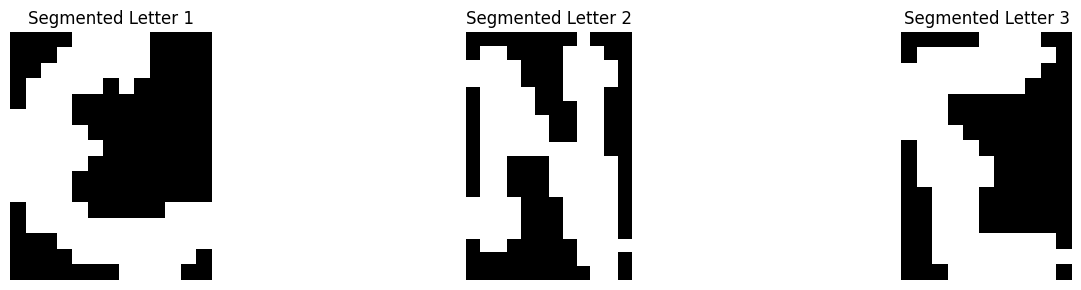

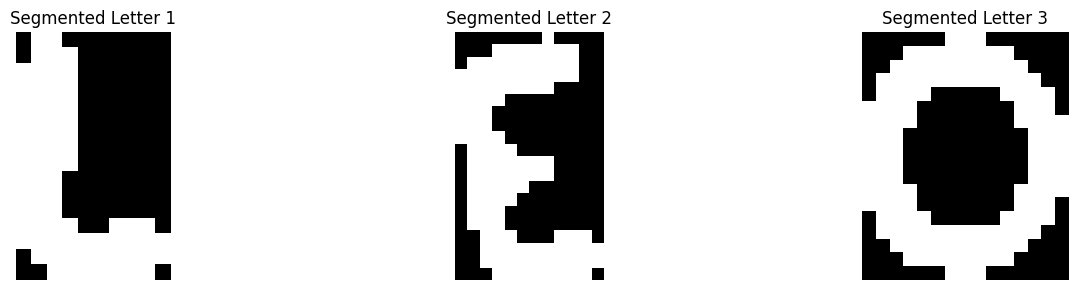

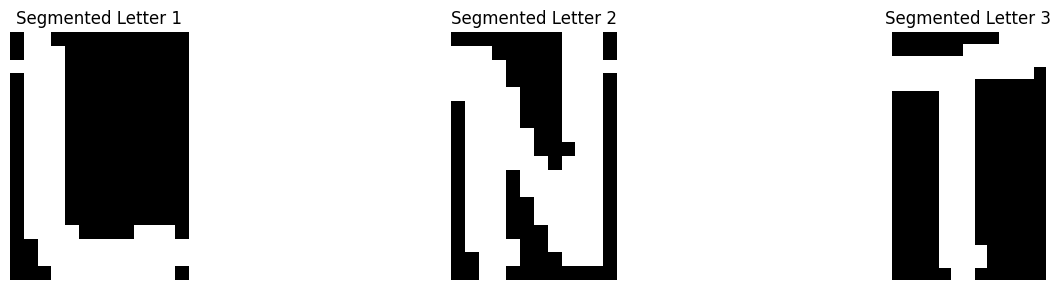

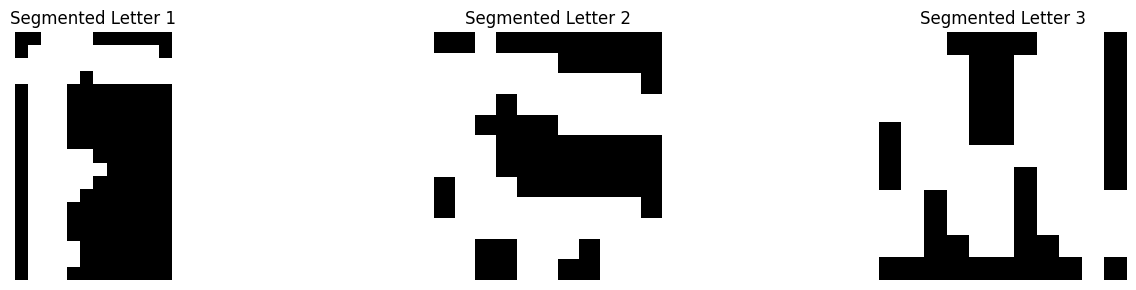

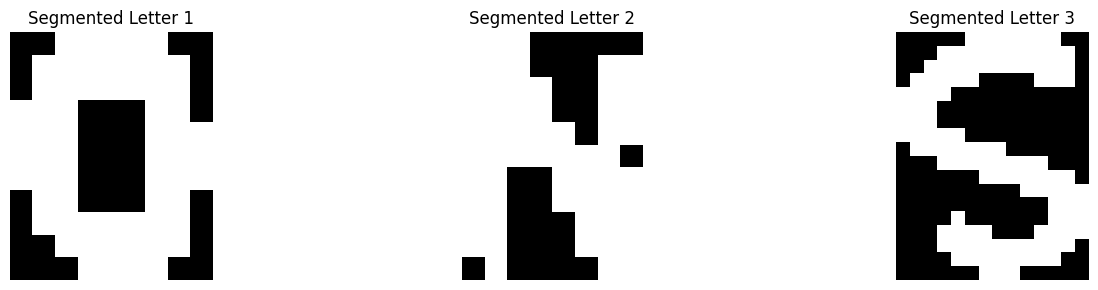

In [ ]:
import numpy as np
import cv2
import os

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def binarize_image(image):
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    return binary

def segment_letters(image):
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmented_letters = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        contour_area = cv2.contourArea(contour)
        if contour_area < 10:
            continue
        letter = image[y:y+h, x:x+w].copy()  # Make a copy to prevent memory issues
        segmented_letters.append(letter)

    return segmented_letters

def extract_features(image):
    # Placeholder function for feature extraction
    # You would replace this with actual feature extraction methods
    return np.random.rand(10)  # Dummy feature vector

def process_images(images):
    processed_data = []
    segmented_letters_all = []

    for image in images:
        # Preprocess the image
        processed_image = preprocess_image(image)

        # Binarize the image
        binary_image = binarize_image(processed_image)

        # Segment letters in the image
        segmented_letters = segment_letters(binary_image)
        segmented_letters_all.extend(segmented_letters)  # Store segmented letters

        # Extract features from segmented letters
        for letter_image in segmented_letters:
            features = extract_features(letter_image)
            processed_data.append(features)

    return np.array(processed_data), segmented_letters_all

# Load images from a directory in batches
def load_images_from_directory(directory, batch_size):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath)
            if image is not None:
                images.append(image)
            else:
                print(f"Failed to load image: {filepath}")

            # Check if the batch size is reached
            if len(images) >= batch_size:
                yield images
                images = []

    # Yield remaining images (if any)
    if images:
        yield images

# Define batch size
batch_size = 10

# Process images in batches
train_dir = "/content/train_v2/train/"
processed_data_all = []
segmented_letters_all = []
for batch_images in load_images_from_directory(train_dir, batch_size):
    batch_processed_data, batch_segmented_letters = process_images(batch_images)
    processed_data_all.extend(batch_processed_data)
    segmented_letters_all.extend(batch_segmented_letters)

# Visualize segmented letters for the first few samples
import matplotlib.pyplot as plt

num_samples = 5
for i in range(num_samples):
    plt.figure(figsize=(15, 3))
    sample_letters = segmented_letters_all[i*3:i*3+3]  # Change the range to visualize first 5 samples
    for j, letter in enumerate(sample_letters):
        plt.subplot(1, 3, j + 1)
        plt.imshow(letter, cmap='gray')
        plt.title(f'Segmented Letter {j+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
#2

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 1))

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(26, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(preprocessed_data, labels, epochs=10, batch_size=32, validation_split=0.2)